# 7. Clustering Systems Using Street Network Data

In [6]:
# load relevant packages for analysis
import cityseer as cs
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import graph_tool.all as gt
import geopandas as gpd
import igraph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, MultiPoint
from shapely.geometry import LineString, MultiLineString
from shapely.ops import nearest_points
import shapely.wkt
import statsmodels.api as sm
import sys
from xml import etree

One of the primary goals of this research is to determine a better way to categorise the urban systems within the UK. At this point in our analysis we have used a clustering approach to determine the urban systems that exist in the UK. 

We have assessed these Urban Systems using several measures and as a result we have developed the following attributes for our network
1. Betweeness Centrality of Nodes and Edges
2. Node Count
3. Diameter
4. Edge Length
5. Occupation Probability
6. Node Angle
7. *Score*: Simplified Fractal Dimension (*Diameter / Node Count*)

Using these attrbutes we will conduct a clustering analysis to determine if we can categorise the urban systems in the UK in a more nuanced and intelligent way.

## Agglomerative Hierarchical Clustering

**Hierarchical Clustering** will highlight the nested structure of your clusters and determine meaningful groupings at various levels of granularity.

**Agglomerative (Bottom-Up)**: Starts with each point as its own cluster and merges the closest pairs of clusters iteratively. Given the goal to develop a taxonomy based on existing clusters, an agglomerative hierarchical clustering would be most appropriate. This method will help you see how smaller clusters merge into larger ones, providing a clear structure for your taxonomy.

In [3]:
G = nx.read_graphml("Data/G300_betw.graphml")

In [4]:
# minimum cluster size of 190 intersections
# filter clusters by size
clusters_190 = [c for c in nx.connected_components(G) if len(c) > 190]
print(f"Number of clusters (cities) identified: {len(clusters_190)}")

Number of clusters (cities) identified: 1483


In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 3161041
Number of edges: 3448220


In [6]:
list(G.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)',
  'occupation_probability': 0.00927614779300641})

In [7]:
list(G.nodes(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)',
  'angle': 126.44988586701946,
  'occupation_probability': 0.7024993659278859})

We will continue to use graph_tool as opposed to networkx due to spead and computational intensity and thus we require the following code to convert this into a useable format.

In [2]:
# init cluster attributes
cluster_attributes = []

In [1]:
# convert graph to graph-tool
def nx_to_gt(nx_graph):
    gt_graph = gt.Graph(directed=False)
    nx_to_gt_map = {}

    for node in nx_graph.nodes():
        nx_to_gt_map[node] = gt_graph.add_vertex()

    # prpeare edge properties
    edge_properties = {}
    for u, v, data in nx_graph.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (int, float)) and key not in edge_properties:
                edge_properties[key] = gt_graph.new_edge_property("double")

    for u, v, data in nx_graph.edges(data=True):
        e = gt_graph.add_edge(nx_to_gt_map[u], nx_to_gt_map[v])
        for key, value in data.items():
            if key in edge_properties and isinstance(value, (int, float)):
                edge_properties[key][e] = value

    for key, prop in edge_properties.items():
        gt_graph.edge_properties[key] = prop

    return gt_graph

In [8]:
# convert clusters to subgraphs
for idx, cluster in enumerate(clusters_190):
    print(f"Processing cluster {idx+1}/{len(clusters_190)}")  # Progress logging

    # subgraphs from nodes in cluster
    cluster_subgraph = G.subgraph(cluster).copy()
    
    # placeholder for calculated attributes
    cluster_data = {
        'cluster_id': idx,
        'nodes': list(cluster),
        'edges': list(cluster_subgraph.edges(data=True)),
        'geometry': list(nx.get_edge_attributes(cluster_subgraph, 'geometry').values())
    }
    cluster_attributes.append(cluster_data)

Processing cluster 1/1483
Processing cluster 2/1483
Processing cluster 3/1483
Processing cluster 4/1483
Processing cluster 5/1483
Processing cluster 6/1483
Processing cluster 7/1483
Processing cluster 8/1483
Processing cluster 9/1483
Processing cluster 10/1483
Processing cluster 11/1483
Processing cluster 12/1483
Processing cluster 13/1483
Processing cluster 14/1483
Processing cluster 15/1483
Processing cluster 16/1483
Processing cluster 17/1483
Processing cluster 18/1483
Processing cluster 19/1483
Processing cluster 20/1483
Processing cluster 21/1483
Processing cluster 22/1483
Processing cluster 23/1483
Processing cluster 24/1483
Processing cluster 25/1483
Processing cluster 26/1483
Processing cluster 27/1483
Processing cluster 28/1483
Processing cluster 29/1483
Processing cluster 30/1483
Processing cluster 31/1483
Processing cluster 32/1483
Processing cluster 33/1483
Processing cluster 34/1483
Processing cluster 35/1483
Processing cluster 36/1483
Processing cluster 37/1483
Processing

In [9]:
# clusters > graph-tool format with status tracking
total_clusters = len(cluster_attributes)
for idx, cluster_data in enumerate(cluster_attributes):
    nx_subgraph = G.subgraph(cluster_data['nodes']).copy()
    gt_subgraph = nx_to_gt(nx_subgraph)
    cluster_data['gt_graph'] = gt_subgraph
    print(f"Cluster {idx+1}/{total_clusters} conversion complete.")

Cluster 1/1483 conversion complete.
Cluster 2/1483 conversion complete.
Cluster 3/1483 conversion complete.
Cluster 4/1483 conversion complete.
Cluster 5/1483 conversion complete.
Cluster 6/1483 conversion complete.
Cluster 7/1483 conversion complete.
Cluster 8/1483 conversion complete.
Cluster 9/1483 conversion complete.
Cluster 10/1483 conversion complete.
Cluster 11/1483 conversion complete.
Cluster 12/1483 conversion complete.
Cluster 13/1483 conversion complete.
Cluster 14/1483 conversion complete.
Cluster 15/1483 conversion complete.
Cluster 16/1483 conversion complete.
Cluster 17/1483 conversion complete.
Cluster 18/1483 conversion complete.
Cluster 19/1483 conversion complete.
Cluster 20/1483 conversion complete.
Cluster 21/1483 conversion complete.
Cluster 22/1483 conversion complete.
Cluster 23/1483 conversion complete.
Cluster 24/1483 conversion complete.
Cluster 25/1483 conversion complete.
Cluster 26/1483 conversion complete.
Cluster 27/1483 conversion complete.
Cluster 28

### Derive additional attributes Needed to Conduct Clustering
1. Calculate Mean Betweenness Centrality for each cluster.
2. Aggregate Other Attributes:
3. Mean Edge Length
4. Mean Occupation Probability
5. Mean Node Angle

# Process Each Cluster and Create Subgraphs

## 2. Calculate Mean Betweenness Centrality for Each Cluster

In [10]:
for cluster_data in cluster_attributes:
    gt_subgraph = cluster_data['gt_graph']
    
    _, e_betweenness = gt.betweenness(gt_subgraph)
    
    mean_betweenness = np.mean(list(e_betweenness.a))
    
    cluster_data['mean_betweenness'] = mean_betweenness

## 3. Calculate Mean Edge Length

In [11]:
for cluster_data in cluster_attributes:
    mean_edge_length = np.mean([data['length'] for u, v, data in cluster_data['edges']])
    cluster_data['mean_edge_length'] = mean_edge_length

## 4. Calculate Mean Occupation Probability

In [12]:
for cluster_data in cluster_attributes:
    mean_occupation_probability = np.mean([data['occupation_probability'] for u, v, data in cluster_data['edges']])
    cluster_data['mean_occupation_probability'] = mean_occupation_probability

## 5. Calculate Mean Node Angle

In [13]:
for cluster_data in cluster_attributes:
    cluster_subgraph = G.subgraph(cluster_data['nodes']).copy()
    mean_node_angle = np.mean([data['angle'] for n, data in cluster_subgraph.nodes(data=True)])
    cluster_data['mean_node_angle'] = mean_node_angle

## 6. Include Diameter, Node Count and Simplified Fractal Dimension (Score)

In [14]:
for cluster_data in cluster_attributes:
    gt_subgraph = cluster_data['gt_graph']
    
    diameter = gt.pseudo_diameter(gt_subgraph)[0]
    node_count = gt_subgraph.num_vertices()
    
    score = diameter / node_count if node_count > 0 else 0
    
    cluster_data['diameter'] = diameter
    cluster_data['node_count'] = node_count
    cluster_data['score'] = score

### Convert node geometries to a convex hull representing the cluster's perimeter

In [18]:
for cluster_data in cluster_attributes:
    node_positions = []
    for node in cluster_data['nodes']:
        pos = G.nodes[node]['pos']
        if isinstance(pos, str):
            pos = pos.strip('()').split(',')
            pos = tuple(map(float, pos))
        else:
            pos = tuple(pos)
        node_positions.append(pos)
    
    if node_positions:
        multipoint = MultiPoint(node_positions)
        cluster_data['geometry'] = multipoint.convex_hull
    else:
        cluster_data['geometry'] = None

## 7. Convert to DataFrame

In [25]:
# convert the list of cluster data to a DataFrame
cluster_df = pd.DataFrame(cluster_attributes)
cluster_gdf = gpd.GeoDataFrame(cluster_df, geometry='geometry')
cluster_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   cluster_id                   1483 non-null   int64   
 1   nodes                        1483 non-null   object  
 2   edges                        1483 non-null   object  
 3   geometry                     1483 non-null   geometry
 4   gt_graph                     1483 non-null   object  
 5   mean_betweenness             1483 non-null   float64 
 6   mean_edge_length             1483 non-null   float64 
 7   mean_occupation_probability  1483 non-null   float64 
 8   mean_node_angle              1483 non-null   float64 
 9   diameter                     1483 non-null   float64 
 10  node_count                   1483 non-null   int64   
 11  score                        1483 non-null   float64 
dtypes: float64(6), geometry(1), int64(2), object(3)
memory

In [26]:
cluster_gdf.head()

,cluster_id,nodes,edges,geometry,gt_graph,mean_betweenness,mean_edge_length,mean_occupation_probability,mean_node_angle,diameter,node_count,score
0,0,"[4A099A18-B5B4-4441-B9A8-6E9D5D94260B, 4EE7237...","[(4A099A18-B5B4-4441-B9A8-6E9D5D94260B, 6BE724...","POLYGON ((147856.290 842460.540, 147786.760 84...","<Graph object, undirected, with 253 vertices a...",0.060478,87.315217,0.004498,73.053040,42.0,253,0.166008
1,1,"[BB48B65F-2972-4690-B7C6-E885404A4FAD, B0FF625...","[(BB48B65F-2972-4690-B7C6-E885404A4FAD, 1D4561...","POLYGON ((445700.600 1139775.600, 445380.750 1...","<Graph object, undirected, with 347 vertices a...",0.042103,86.012107,0.004430,79.728860,40.0,347,0.115274
2,2,"[A6B72B43-B144-46EE-9FA3-B9CC16A8A217, 8E36ED2...","[(A6B72B43-B144-46EE-9FA3-B9CC16A8A217, 4C1BB8...","POLYGON ((337055.210 399569.490, 336781.210 39...","<Graph object, undirected, with 1042 vertices ...",0.023680,82.574451,0.004251,85.582433,85.0,1042,0.081574
3,3,"[058C872C-DD92-4CB3-91C3-A67CCDAD0E81, B6EF7BB...","[(058C872C-DD92-4CB3-91C3-A67CCDAD0E81, EB13CB...","POLYGON ((442423.310 110168.450, 438452.000 11...","<Graph object, undirected, with 4374 vertices ...",0.009824,80.132211,0.004124,83.729627,146.0,4374,0.033379
4,4,"[C31BA8A5-C6DB-47EC-9FEE-7A0C674E33C2, CA9FCB5...","[(C31BA8A5-C6DB-47EC-9FEE-7A0C674E33C2, B1482F...","POLYGON ((388676.130 337469.630, 388074.320 33...","<Graph object, undirected, with 15509 vertices...",0.005618,74.431913,0.003827,87.087898,353.0,15509,0.022761


In [3]:
cluster_gdf.info()

NameError: name 'cluster_gdf' is not defined

In [8]:
cluster_gdf = gpd.read_file('Data/Archive/clusterdata.csv')

ERROR:fiona._env:Maximum number of characters allowed reached.


ValueError: GeoDataFrame does not support multiple columns using the geometry column name 'geometry'.

In [27]:
# save as csv
cluster_gdf.to_csv('Data/clusterdata.csv')

print(f"Cluster data saved")

Cluster data saved


## 8. Clustering

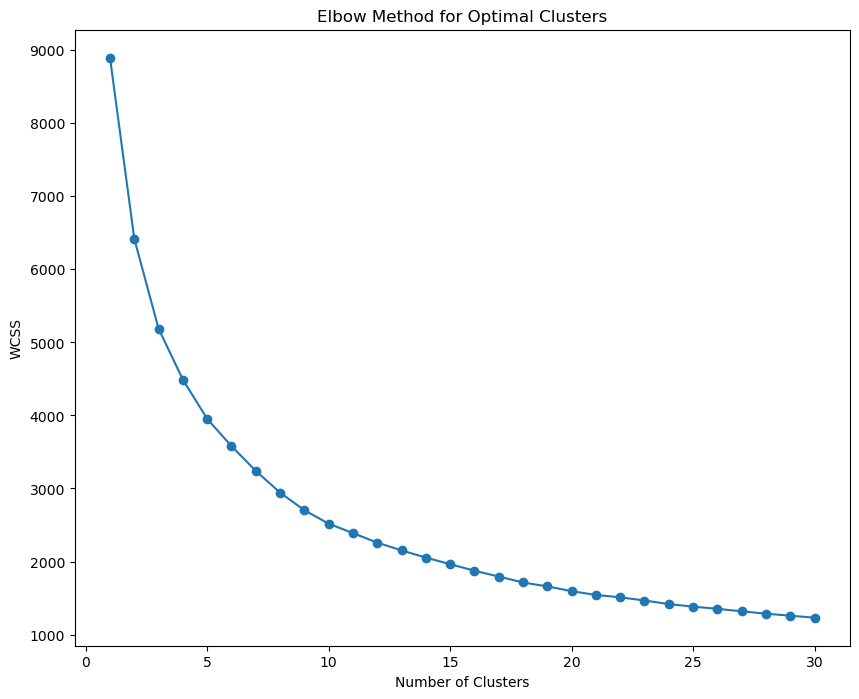

In [30]:
def plot_elbow_method(features_scaled):
    wcss = []
    for i in range(1, 31):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(features_scaled)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 31), wcss, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()

plot_elbow_method(features_scaled)

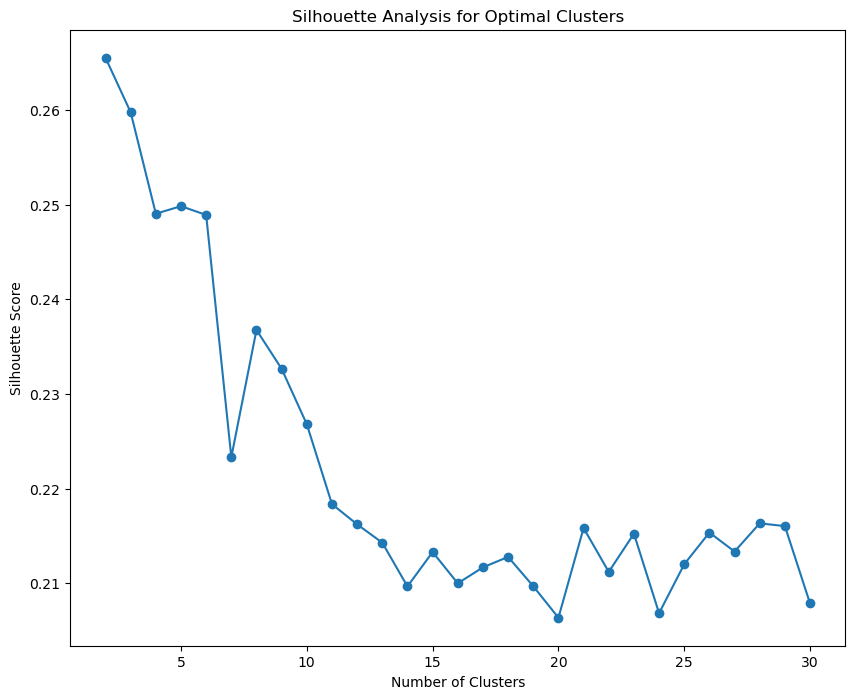

In [37]:
def silhouette_analysis(features_scaled):
    silhouette_scores = []
    for n_clusters in range(2, 31):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        labels = kmeans.fit_predict(features_scaled)
        score = silhouette_score(features_scaled, labels)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 8))
    plt.plot(range(2, 31), silhouette_scores, marker='o')
    plt.title('Silhouette Analysis for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

silhouette_analysis(features_scaled)

In [32]:
# select columns for the second clustering
attributes = ['mean_betweenness', 'mean_edge_length', 'mean_occupation_probability', 'mean_node_angle', 'diameter', 'score']
features = cluster_gdf[attributes]

# standardise
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# agglomerative clustering
optimal_clusters = 12
clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
cluster_gdf['new_cluster'] = clustering.fit_predict(features_scaled)

# calc. mean of each attribute
cluster_means = cluster_gdf.groupby('new_cluster')[attributes].mean()

In [36]:
from scipy.stats import pointbiserialr

In [37]:
# intiialise df to store correlation results
correlation_df = pd.DataFrame(index=range(optimal_clusters), columns=attributes)

# calc biserial correlation
for cluster in range(optimal_clusters):
    binary_cluster = (cluster_gdf['new_cluster'] == cluster).astype(int)
    for attribute in attributes:
        correlation, _ = pointbiserialr(binary_cluster, cluster_gdf[attribute])
        correlation_df.at[cluster, attribute] = correlation

# convert columns to numeric
correlation_df = correlation_df.apply(pd.to_numeric)

In [38]:
correlation_df

,mean_betweenness,mean_edge_length,mean_occupation_probability,mean_node_angle,diameter,score
0,0.429881,0.160827,0.160827,-0.157592,-0.152090,0.442664
1,-0.227729,-0.026719,-0.026719,0.072691,0.604225,-0.236273
2,0.162021,-0.234125,-0.234125,0.182385,-0.124932,0.188297
3,0.209993,-0.329429,-0.329429,-0.312269,-0.132656,0.175144
4,-0.452996,-0.033907,-0.033907,0.174610,0.394565,-0.447792
5,0.058148,0.004030,0.004030,0.330830,-0.058080,0.108703
6,-0.023883,0.364684,0.364684,-0.008733,-0.105845,-0.025619
7,0.334610,0.548195,0.548195,-0.006400,-0.104093,0.358517
8,-0.183628,0.081527,0.081527,-0.213723,-0.044037,-0.209215
9,-0.179256,-0.402944,-0.402944,0.390451,0.046738,-0.153487
